# Preproces AIS data

Load data for a specific region and time period and extract trajectories of ships.

In [170]:
# imports
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd
import gym
import datetime

import os, sys

import numpy as np


from ferrygym import FerryGymEnv, Ship
from MapRevMoenk import *
from plot_helpers import plot_single_frame

## Load data

Our AIS data is stored at a Postgres server at our institute's server.
To access the data a GraphQL API is provided through [Hasura](https://hasura.io/).


In [171]:
# connect to api
# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="http://172.23.0.4:8080/v1/graphql",
    headers={'content-type': 'application/json',
        'x-hasura-admin-secret': 'aaasdsdndsfvksdsd'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# Provide a GraphQL query
query = gql(
    """
    query MyQuery(
  $lteTimeString: String!,
  $gteTimeString: String!,
  $bound_bottom: float8!,
  $bound_top: float8!,
  $bound_left: float8!,
  $bound_right: float8!,
  $minSpeed: float8!) {
      ais(limit: 10000000, where: {
        datetime: {_lt: $lteTimeString, _gte: $gteTimeString},
        lon: {_is_null: false, _gte: $bound_left, _lte: $bound_right},
        lat: {_is_null: false, _gte: $bound_bottom, _lte: $bound_top},
        speed: {_is_null: false, _gt: $minSpeed},
        }) {
            mmsi
            datetime
            lat
            lon
            speed
            heading
            }
    }
"""
)

params = {"lteTimeString": "2022-04-07 12:00:00+00", "gteTimeString": "2022-04-01 12:00:00+00", "bound_right": BOUND_RIGHT, "bound_left": BOUND_LEFT, "bound_top": BOUND_TOP, "bound_bottom": BOUND_BOTTOM, "minSpeed": 0.3 }
print(params)

DATASET_NAME = 'rev-moenk-22-04-01-12-00--04-07'

# Execute the query on the transport
result = await client.execute_async(query, variable_values=params)
df = pd.DataFrame(result['ais'])
# get min datetime in df
print('start data: ', df['datetime'].min())
# get max datetime in df
print('end date: ',df['datetime'].max())
# print min speed
print('min speed: ',df['speed'].min())
# print max speed
print('max speed: ',df['speed'].max())

{'lteTimeString': '2022-04-07 12:00:00+00', 'gteTimeString': '2022-04-01 12:00:00+00', 'bound_right': 10.190433, 'bound_left': 10.141767, 'bound_top': 54.352733, 'bound_bottom': 54.325583, 'minSpeed': 0.3}
start data:  2022-04-01 12:00:00+00
end date:  2022-04-07 11:59:56+00
min speed:  0.4
max speed:  102.3


In [172]:
# replace each mmsi with a unique integer
mmsi_list = df['mmsi'].unique()
mmsi_dict = {mmsi_list[i]: i for i in range(len(mmsi_list))}
df['mmsi'] = df['mmsi'].map(mmsi_dict)

In [173]:
# Convert in env coordinates

kwargs = dict(
    generate_training_data=True,
    data_directory='/workspace/data/rev-moenk/training/',
    df_filename='2022-04-10-13->14.pkl',
)

env = FerryGymEnv.FerryGymEnv(**kwargs)
# iterate though rows
for index, row in df.iterrows():
    # get x,y from env.convertLatonInEnvCoordinates
    x, y = env.convertLatLotInEnvCoordinates(row['lat'], row['lon'])
    # set x,y in df
    df.at[index, 'x'] = x
    df.at[index, 'y'] = y

/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [174]:
# interpolate_trajectories to generate position data for every second

df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df_grouped = df.groupby(['mmsi'])
df_resampled = df_grouped.resample('1S', on='datetime').mean()
df_interpol = df_resampled.interpolate()

In [175]:
# add index column and reset index
df =  df_interpol.reset_index(level=['datetime'])
# add new index column numbering the rows
df['index'] = range(0, len(df))
df.set_index('index', inplace=True)

### Calculate speed, acceleration, direction and direction_change

In [176]:
# calculate current speed and save in new column
timedelta = datetime.timedelta(seconds=1)

df['dist_x'] = df['x'].diff().fillna(0.)
df['dist_y'] = df['y'].diff().fillna(0.)
df['dist'] = (df['dist_x']**2 + df['dist_y']**2)**0.5
# add column for speed in m/s (speed column is in knots)
speed_calculated = df['dist'] / timedelta.total_seconds()
df['speed_calculated'] = speed_calculated 
# print min speed_calculated
print('min speed_calculated: ',df['speed_calculated'].min())
# print max speed_calculated
print('max speed_calculated: ',df['speed_calculated'].max())
# count speed_calculated == 0
print('count speed_calculated == 0: ',df['speed_calculated'].eq(0).sum())



min speed_calculated:  0.0
max speed_calculated:  3207.9212393395032
count speed_calculated == 0:  4292


In [177]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['dist_x']            = df['x'].diff().fillna(0.)
df['dist_y']            = df['y'].diff().fillna(0.)
df['dist']              = (df['dist_x']**2 + df['dist_y']**2)**0.5
df['speed_calculated']  = df['dist'] / timedelta.total_seconds()
df['direction']         = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [178]:
 # calculate acceleration and save in new column
acceleration = df['speed_calculated'].diff().fillna(0.)
df['acceleration'] = acceleration / timedelta.total_seconds()
# move one row up to match state
df['acceleration'] = df['acceleration'].shift(-1)

In [179]:
import numpy as np
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

df['direction'] = angle_between([0, 1], [df['dist_x'], -1 * df['dist_y']])

In [180]:
# add direction_change column
df['direction_change'] = df['direction'].diff().fillna(0)
# move one row up to match state
df['direction_change'] = df['direction_change'].shift(-1)

In [181]:
# clean up first and last row in group
mask_last_row_of_ship = df.mmsi != df.mmsi.shift(-1)
# mask_time_gap = df.datetime != df.datetime.shift(1) - timedelta
df['acceleration'][mask_last_row_of_ship] = 0
df['direction_change'][mask_last_row_of_ship] = 0
mask_first_row_of_ship = df.mmsi != df.mmsi.shift(1)
df['acceleration'][mask_first_row_of_ship] = 0
df['direction_change'][mask_first_row_of_ship] = 0
df['speed_calculated'][mask_first_row_of_ship] = df['speed_calculated'].shift(1)
df['direction'][mask_first_row_of_ship] = df['direction'].shift(1)

/tmp/ipykernel_612477/4075781168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_last_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction_change'][mask_last_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'][mask_first_row_of_ship] = 0
/tmp/ipykernel_612477/4075781168.py:8: Se

In [182]:
# round actions to 2 decimals
df['acceleration'] = df['acceleration'].round(2)
df['direction_change'] = df['direction_change'].round(2)

In [183]:
# replace nan with 0
df['acceleration'] = df['acceleration'].fillna(0)
df['direction_change'] = df['direction_change'].fillna(0)
df['speed_calculated'] = df['speed_calculated'].fillna(0)
df['direction'] = df['direction'].fillna(0)

In [184]:
def move_around_the_clock(direction_change):
    if abs(direction_change) > 180:
        if direction_change > 0:
            return direction_change - 360
        else:
            return direction_change + 360
    else:
        return direction_change

df['direction_change'] = df['direction_change'].apply(move_around_the_clock)

In [185]:
# reduce to important columns
df = df[['mmsi', 'datetime', 'x', 'y', 'speed_calculated', 'acceleration', 'direction', 'direction_change']]

In [186]:
df.describe()

,mmsi,x,y,speed_calculated,acceleration,direction,direction_change
count,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06,8.938526e+06
mean,2.087883e+01,1.225220e+03,1.507512e+03,1.661834e-01,-1.562898e-06,1.973425e+02,-1.686750e-03
std,1.349281e+01,5.665176e+02,1.280748e+03,1.059489e+00,7.883400e-02,9.075348e+01,1.983926e+00
min,0.000000e+00,1.743219e+02,0.000000e+00,0.000000e+00,-2.176000e+01,0.000000e+00,-1.800000e+02
25%,1.000000e+01,6.464050e+02,2.269204e+01,3.534664e-04,0.000000e+00,1.021056e+02,0.000000e+00
50%,1.800000e+01,1.096915e+03,1.914492e+03,1.141156e-03,0.000000e+00,2.445388e+02,0.000000e+00
75%,3.100000e+01,1.646835e+03,2.697048e+03,2.524116e-03,0.000000e+00,2.701595e+02,0.000000e+00
max,5.400000e+01,2.825311e+03,3.018942e+03,2.234272e+03,2.638000e+01,3.598309e+02,1.800000e+02


### Generate neighborhood images

In [195]:
from pandarallel import pandarallel

import os

os.environ['MEMORY_FS_ROOT'] = '/test'
pandarallel.initialize(progress_bar=True, use_memory_fs=True, nb_workers=8, verbose=2)

def generate_images_for_group(group):
    ships = []
    for index, row in group.iterrows():
        ship = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
        ships.append(ship)
    for index, row in group.iterrows():
        agent = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
        neighborhood = env.render_neighborhood(agent, ships)
        # np save image in image directory
        filename = str(row['mmsi']) + '_' + row['datetime'].strftime ('%Y-%m-%d_%H-%M-%S') + '.npy' 
        np.save('../data/' + DATASET_NAME + '/images/' + filename, neighborhood)
        # add filename to df
        group.at[index, 'filename'] = filename
    return group
        


df_neighborhood = df.groupby(['datetime']).parallel_apply(generate_images_for_group)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/root/.cache/pypoetry/virtualenvs/ppuu-ferrygym-xS3fZVNL-py3.8/lib/python3.8/site-packages/pandarallel/data_types/dataframe_groupby.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  iterator = iter(dataframe_groupby)


OSError: [Errno 28] No space left on device

In [190]:
import concurrent.futures
from functools import partial

def process_group(df, datetime_group, func):
    group = df[df['datetime'] == datetime_group]
    return datetime_group, func(datetime_group, group)

with concurrent.futures.ProcessPoolExecutor() as executor:
    func = partial(generate_images_for_group)
    
    datetime_groups = df['datetime'].unique()
    args = [(df, dt, func) for dt in datetime_groups]
    
    results = list(executor.map(lambda x: process_group(*x), args))

df_neighborhood = pd.concat([group for dt, group in results]).sort_index()

KeyboardInterrupt: 

In [42]:
# save df to pickle file
print('Saving df to pickle file')
df.to_pickle('../data/' + DATASET_NAME + '.pkl')

### Visualize data

In [165]:
groups = pd.concat( [ df_grouped.get_group(group) for i,group in enumerate( df_grouped.groups) if i < 1000 ] ).groupby('datetime')


In [167]:
group = groups.get_group('2022-04-01 12:07:22+00:00')
group

,mmsi,datetime,x,y,speed_calculated,acceleration,direction,direction_change
index,,,,,,,,
438,0.0,2022-04-01 12:07:22+00:00,749.598732,2217.044832,0.007256,-0.0,7.659794,-0.0
1354299,9.0,2022-04-01 12:07:22+00:00,684.798014,2618.280701,0.261782,-0.0,90.683641,-0.0
1855906,10.0,2022-04-01 12:07:22+00:00,774.700280,2170.080188,0.011394,0.0,270.000000,0.0
2829191,14.0,2022-04-01 12:07:22+00:00,883.063876,1911.746665,0.007760,0.0,288.940924,0.0
6122752,30.0,2022-04-01 12:07:22+00:00,1026.490369,2446.232789,4.499273,-0.0,39.326476,0.0
6991963,32.0,2022-04-01 12:07:22+00:00,1054.774153,1543.532359,0.023071,-0.0,140.456096,0.0


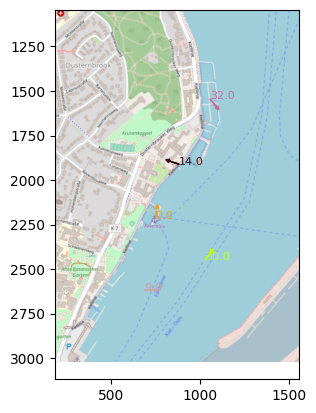

In [168]:
plot_single_frame(group)


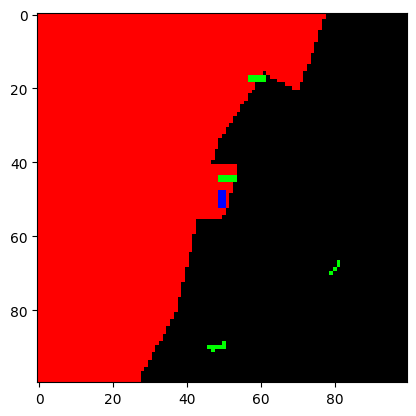

In [169]:
# create ship object for every row in group
ships = []
for index, row in group.iterrows():
    ship = Ship.Ship((row['x'], row['y']), row['direction'], 1, row['mmsi'])
    ships.append(ship)

first_row = group.iloc[0]
agent = Ship.Ship((first_row['x'], first_row['y']), first_row['direction'], 1, first_row['mmsi'])
# render neighborhood
neighborhood = env.render_neighborhood(agent, ships)
# plot neighborhood
plt.imshow(neighborhood)